References:

*   https://www.nature.com/articles/s41597-021-01055-x
*   https://www.sciencedirect.com/science/article/pii/S0378778818300100

*   https://www.sciencedirect.com/science/article/pii/S0306261920306474

*   file:///C:/Users/moham/Downloads/electronics-10-02599.pdf

*   https://www.sciencedirect.com/science/article/pii/S0360132321005345#coi0010
*   https://www.kaggle.com/code/ihsncnkz/rnn-and-lstm-with-keras

*   https://www.kaggle.com/code/amansrivastava/exploration-bi-lstm-model/notebook









In [ ]:
import math
import seaborn as sns
from google.colab import data_table
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


from numpy import newaxis
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Dense, Input, LSTM, Dropout, Bidirectional, Embedding
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.preprocessing import RobustScaler, MinMaxScaler, PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA


from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,f1_score

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPRegressor

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,f1_score


In [ ]:
import torch
torch.cuda.is_available

<function torch.cuda.is_available() -> bool>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Call Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/WPI/Deep Learning/Project/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

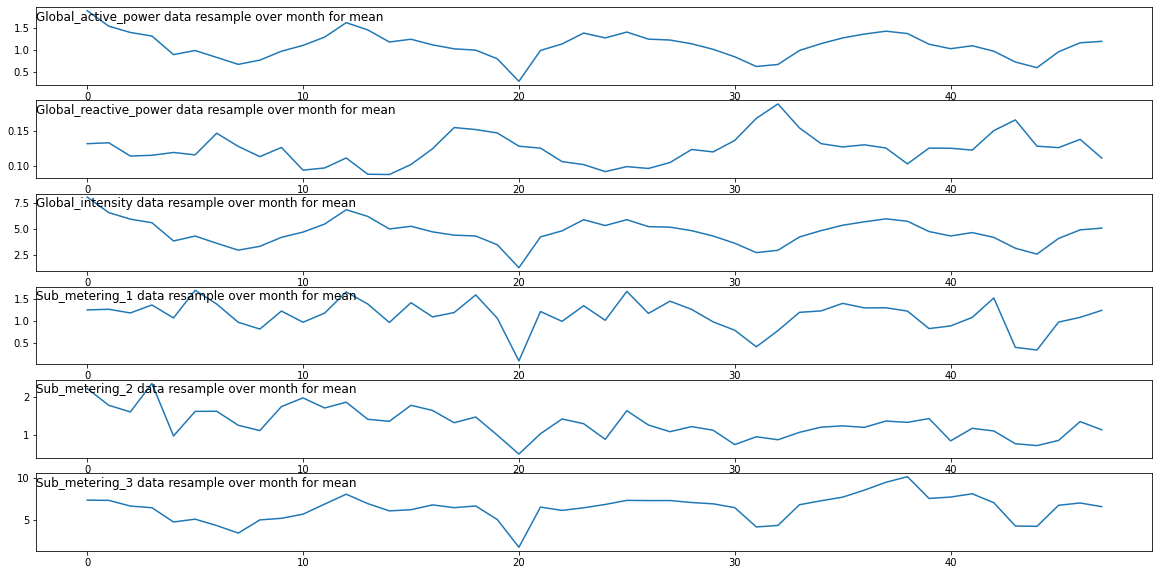

In [ ]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('M').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over month for mean', y=0.75, loc='left')
    i += 1
plt.show()

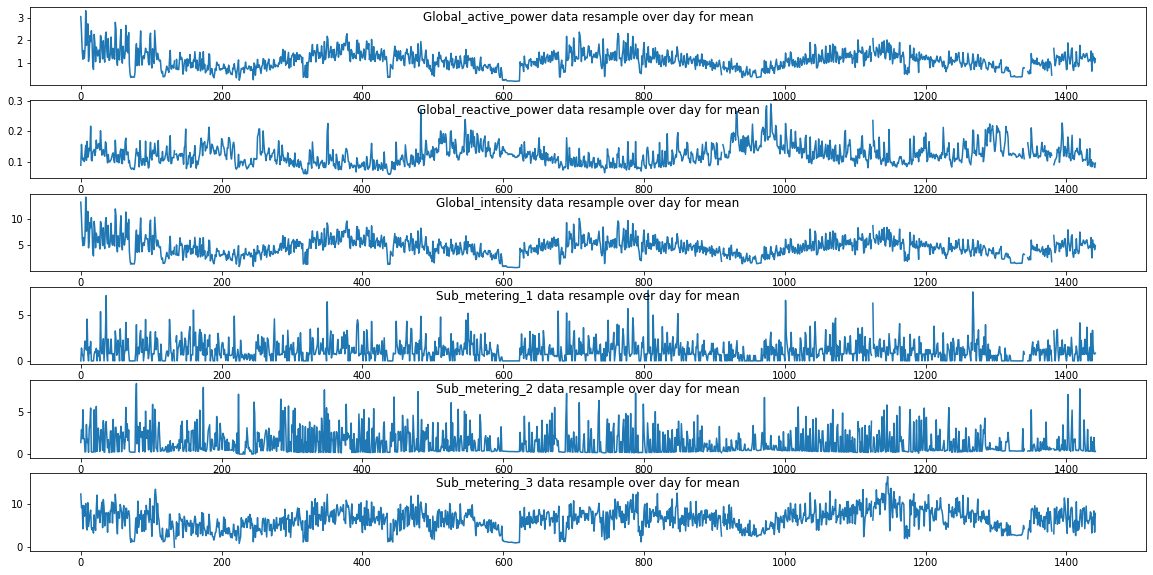

In [ ]:

i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('D').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over day for mean', y=0.75, loc='center')
    i += 1
plt.show()

In [ ]:
df = df[['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_1','Sub_metering_3']]
       
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [ ]:
# take hours of the dataset only
df_resample = df.resample('h').mean() 
df_resample.shape

df_resample.head(-1)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_2,Sub_metering_1,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.527778,0.0,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,6.716667,0.0,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,1.433333,0.0,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.000000,0.0,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.416667,0.0,17.216667
...,...,...,...,...,...,...,...
2010-11-26 16:00:00,1.067933,0.215633,240.457833,4.610000,0.950000,0.0,0.000000
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.000000,0.0,12.866667
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.000000,0.0,0.000000


In [ ]:
from sklearn.preprocessing import MinMaxScaler

df_resample = df.resample('h').mean() 
df_resample.shape

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.columns = [ 'Global_active_power (t-1)',  'Global_reactive_power (t-1)', 'Voltage (t-1)',
       'Global_intensity (t-1)', 'Sub_metering_2 (t-1)', 'Sub_metering_1 (t-1)','Sub_metering_3 (t-1)', 'Global_active_power (t)']

reframed.head()


,Global_active_power (t-1),Global_reactive_power (t-1),Voltage (t-1),Global_intensity (t-1),Sub_metering_2 (t-1),Sub_metering_1 (t-1),Sub_metering_3 (t-1),Global_active_power (t)
0,0.545045,0.103358,0.335501,0.541487,0.144652,0.0,0.782676,0.636816
1,0.509006,0.110073,0.283802,0.502152,0.030869,0.0,0.774169,0.545045
2,0.488550,0.096987,0.315987,0.481110,0.000000,0.0,0.778809,0.509006
3,0.455597,0.099010,0.434417,0.449904,0.008973,0.0,0.798917,0.488550
4,0.322555,0.072536,0.495847,0.323529,0.002872,0.0,0.205723,0.455597


In [ ]:
len(reframed)

34159

In [ ]:
# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 4000
train = values[:n_train_time, :]
test = values[n_train_time:, :]

X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Machine Learning

In [ ]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
0,0.545045,0.103358,0.335501,0.541487,0.144652,0.0,0.782676,0.636816
1,0.509006,0.110073,0.283802,0.502152,0.030869,0.0,0.774169,0.545045
2,0.488550,0.096987,0.315987,0.481110,0.000000,0.0,0.778809,0.509006
3,0.455597,0.099010,0.434417,0.449904,0.008973,0.0,0.798917,0.488550
4,0.322555,0.072536,0.495847,0.323529,0.002872,0.0,0.205723,0.455597
...,...,...,...,...,...,...,...,...
34583,0.248876,0.079294,0.431003,0.240794,0.000000,0.0,0.597061,0.146652
34584,0.225194,0.069350,0.448732,0.219393,0.000000,0.0,0.000000,0.248876
34585,0.238534,0.077529,0.418395,0.235055,0.001436,0.0,0.000000,0.225194
34586,0.161531,0.078993,0.520246,0.158178,0.022972,0.0,0.000000,0.238534


In [ ]:
X_train[0]

array([[0.54504495, 0.10335773, 0.33550078, 0.54148733, 0.14465183,
        0.        , 0.78267595]])

In [ ]:
n_train_time = 4000

X = reframed.drop('var1(t)', axis = 1)
y = reframed['var1(t)']

X_train = X.iloc[:n_train_time]
y_train = y.iloc[:n_train_time]

X_test = X.iloc[n_train_time:]
y_test = y.iloc[n_train_time:]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures



model = LinearRegression()
model.fit(X_train, y_train)

pred_lr = model.predict(X_test)

score = model.score(X_test, y_test)
score

0.4916119845250353

In [ ]:
print('MSE score : %.4f' % (mean_squared_error(y_test, pred_lr)))
print('ASE score : %.4f' % (mean_absolute_error(y_test, pred_lr)))
print('r2 score : %.4f' % (r2_score(y_test, pred_lr)))


MSE score : 0.0092
ASE score : 0.0701
r2 score : 0.4916


In [ ]:
X = reframed.drop('var1(t)', axis = 1)
y = reframed['var1(t)']

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X)

n_train_time = 4000

X_train = poly_features[:n_train_time]
y_train = y.iloc[:n_train_time]

X_test = poly_features[n_train_time:]
y_test = y.iloc[n_train_time:]

poly_reg = LinearRegression().fit(X_train, y_train)
y_pr = poly_reg.predict(X_test)

print('Coefficient of Determination : %.4f' % (poly_reg.score(X_test, y_test)))
print('MSE score : %.4f' % (mean_squared_error(y_test, y_pr)))
print('ASE score : %.4f' % (mean_absolute_error(y_test, y_pr)))
print('r2 score : %.4f' % (r2_score(y_test, y_pr)))

Coefficient of Determination : 0.4888
MSE score : 0.0093
ASE score : 0.0682
r2 score : 0.4888


In [ ]:
from sklearn.ensemble import RandomForestRegressor

l = int(len(df)/3)*2

X_train = X.iloc[:l]
y_train = y.iloc[:l]

X_test = X.iloc[l:]
y_test = y.iloc[l:]

RF_Reg = RandomForestRegressor(n_estimators = 100, random_state = 0)
  
# fit the regressor with x and y data
RF_Reg.fit(X_train, y_train)


y_rfr = RF_Reg.predict(X_test)

In [ ]:
print('Coefficient of Determination : %.4f' % (RF_Reg.score(X_test, y_test)))
print('MSE score : %.4f' % (mean_squared_error(y_test, y_rfr)))
print('ASE score : %.4f' % (mean_absolute_error(y_test, y_rfr)))
print('r2 score : %.4f' % (r2_score(y_test, y_rfr)))

Coefficient of Determination : 0.7588
MSE score : 0.2239
ASE score : 0.3000
r2 score : 0.7588


In [ ]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ["RBF", "Linear", "Polynomial"]

for label, svr in zip(kernel_label, svrs):
  svr.fit(X_train, y_train)
  y_svr = svr.predict(X_test)

  print('for', label)
  print('Coefficient of Determination : %.4f' % (svr.score(X_test, y_test)))
  print('MSE score : %.4f' % (mean_squared_error(y_test, y_svr)))
  print('ASE score : %.4f' % (mean_absolute_error(y_test, y_svr)))
  print('r2 score : %.4f' % (r2_score(y_test, y_svr)))
  print('\n')


for RBF
Coefficient of Determination : 0.4249
MSE score : 0.0105
ASE score : 0.0837
r2 score : 0.4249


for Linear
Coefficient of Determination : 0.4540
MSE score : 0.0099
ASE score : 0.0793
r2 score : 0.4540


for Polynomial
Coefficient of Determination : 0.4177
MSE score : 0.0106
ASE score : 0.0846
r2 score : 0.4177




# Deep Learning

In [ ]:
df.head()

,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,year,month,day,hour,Weekend
0,4.216,0.000,1.000,17.0,2006,12,16,17,1
1,5.360,0.000,1.000,16.0,2006,12,16,17,1
2,5.374,0.000,2.000,17.0,2006,12,16,17,1
3,5.388,0.000,1.000,17.0,2006,12,16,17,1
4,3.666,0.000,1.000,17.0,2006,12,16,17,1


In [ ]:
# train, validation, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))], shuffle = False)

X = df.drop(['Global_active_power'], axis = 1)
y = df['Global_active_power']

X = np.asarray(X).astype(np.float32) 
y = np.asarray(y).astype(np.float32)


l_t = int(len(df)*0.8)
l_v = int(len(df)*0.1)

X_train = X[:l_t]
y_train = y[:l_t]

X_valid = X[l_t: l_t + l_v]
y_valid = y[l_t: l_t + l_v]

X_test = X[l_t + l_v:]
y_test = y[l_t + l_v:]

In [ ]:
from keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow as tf

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def cf_det(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## MLP

In [ ]:

MLP_model = Sequential()
MLP_model.add(Dense(1024, activation='relu',  input_shape=(X_train.shape[1], X_train.shape[2]) ))
MLP_model.add(Dense(512, activation='relu'))
MLP_model.add(Dense(256,activation='relu'))
MLP_model.add(Dense(128,activation='relu'))
MLP_model.add(Dense(64,activation='relu'))
MLP_model.add(Dropout(0.3))
MLP_model.add(Dense(32,activation='relu'))
MLP_model.add(Dense(16,activation='relu'))
MLP_model.add(Dense(8,activation='relu'))
MLP_model.add(Dense(5,activation='sigmoid'))

MLP_model.compile(optimizer=Adam(learning_rate=1e-3), loss= tf.keras.losses.MeanSquaredError(),  
              metrics=['mse', 'mae', cf_det])

MLP_model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs= 100, batch_size = 64)

Epoch 1/100


InvalidArgumentError: ignored

In [ ]:
# MLP

from tensorflow.keras import layers
import tensorflow as tf

model = Sequential()
model.add(Dense(512, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.0001), loss= tf.keras.losses.MeanSquaredError(), 
              metrics=['mse', 'mae', cf_det])

model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs= 500, batch_size= 235)

In [ ]:
from sklearn.neural_network import MLPRegressor

n_train_time = 4000

X = reframed.drop('var1(t)', axis = 1)
y = reframed['var1(t)']

X_train = X.iloc[:n_train_time]
y_train = y.iloc[:n_train_time]

X_test = X.iloc[n_train_time:]
y_test = y.iloc[n_train_time:]

def MLP_Classifier(act_fctn, layer, X_train, y_train,X_test, y_test):

  nlp_model = MLPRegressor(activation = act_fctn, hidden_layer_sizes = (layer,))
  nlp_model.fit(X_train, y_train)

  y_pred = nlp_model.predict(X_test)

  RMSE = mean_squared_error(y_test, y_pred)
  MAE = mean_absolute_error(y_test, y_pred)
  r2_s = r2_score(y_test, y_pred)
  # accuracy = accuracy_score(y_test, y_pred)*100

  print("RMSE = %.3f " %RMSE, '\n' )
  print("MAE = %.3f " %MAE, '\n' )
  print("Score  = %.3f " %nlp_model.score(X_test, y_test), '% \n' )
  print('r2 score : %.4f' % r2_s)
  print('\n' )

  return nlp_model

act_fcts = ["identity", "logistic", "tanh", "relu"]

layers = np.arange(1, 10, 2)
act_fct = "logistic"

Score_NLC_Id = []; Score_NLC_lg = []; Score_NLC_t = []; Score_NLC_rl = []
Accuracy_NLC_Id = []; Accuracy_NLC_lg = []; Accuracy_NLC_t = []; Accuracy_NLC_rl = []

i = 0

for act_fct in act_fcts:    
  for layer in layers:
    print('for # of layer ==:', layer, 'and activation function:', act_fct)
    model_nlp = MLP_Classifier(act_fct, layer, X_train, y_train,X_test, y_test) 

  i= i+1

for # of layer ==: 1 and activation function: identity


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RMSE = 0.026  

MAE = 0.124  

Score  = -0.435  % 

r2 score : -0.4347


for # of layer ==: 3 and activation function: identity
RMSE = 0.014  

MAE = 0.088  

Score  = 0.248  % 

r2 score : 0.2477


for # of layer ==: 5 and activation function: identity
RMSE = 0.009  

MAE = 0.070  

Score  = 0.489  % 

r2 score : 0.4892


for # of layer ==: 7 and activation function: identity
RMSE = 0.011  

MAE = 0.077  

Score  = 0.398  % 

r2 score : 0.3977


for # of layer ==: 9 and activation function: identity
RMSE = 0.009  

MAE = 0.069  

Score  = 0.494  % 

r2 score : 0.4940


for # of layer ==: 1 and activation function: logistic
RMSE = 0.021  

MAE = 0.124  

Score  = -0.180  % 

r2 score : -0.1803


for # of layer ==: 3 and activation function: logistic
RMSE = 0.011  

MAE = 0.086  

Score  = 0.377  % 

r2 score : 0.3772


for # of layer ==: 5 and activation function: logistic
RMSE = 0.010  

MAE = 0.076  

Score  = 0.450  % 

r2 score : 0.4497


for # of layer ==: 7 and activation functio

## CNN

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='valid', input_shape=(X_train.shape[1], X_train.shape[2]))) 
model.add(tf.keras.layers.MaxPooling1D(pool_size=2, padding='valid'))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))


model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', cf_det])

history = model.fit(X_train, y_train, batch_size=512, epochs= 50, validation_data = (X_valid, y_valid))



## LSTM

In [ ]:
# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 4000
train = values[:n_train_time, :]
test = values[n_train_time:, :]

X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', cf_det])

history = model.fit(X_train, y_train, batch_size= 32, epochs= 100, validation_data = (X_test, y_test), verbose=2, shuffle=False)

Epoch 1/100
125/125 - 4s - loss: 0.0247 - mse: 0.0247 - mae: 0.1170 - cf_det: -8.2086e-01 - val_loss: 0.0104 - val_mse: 0.0104 - val_mae: 0.0752 - val_cf_det: -3.9165e+00 - 4s/epoch - 30ms/step
Epoch 2/100
125/125 - 2s - loss: 0.0144 - mse: 0.0144 - mae: 0.0907 - cf_det: 0.0468 - val_loss: 0.0099 - val_mse: 0.0099 - val_mae: 0.0704 - val_cf_det: -1.8521e+00 - 2s/epoch - 16ms/step
Epoch 3/100
125/125 - 2s - loss: 0.0133 - mse: 0.0133 - mae: 0.0860 - cf_det: 0.1359 - val_loss: 0.0096 - val_mse: 0.0096 - val_mae: 0.0692 - val_cf_det: -1.3564e+00 - 2s/epoch - 16ms/step
Epoch 4/100
125/125 - 2s - loss: 0.0127 - mse: 0.0127 - mae: 0.0837 - cf_det: 0.1780 - val_loss: 0.0094 - val_mse: 0.0094 - val_mae: 0.0687 - val_cf_det: -1.1649e+00 - 2s/epoch - 15ms/step
Epoch 5/100
125/125 - 2s - loss: 0.0123 - mse: 0.0123 - mae: 0.0816 - cf_det: 0.2005 - val_loss: 0.0093 - val_mse: 0.0093 - val_mae: 0.0685 - val_cf_det: -1.0321e+00 - 2s/epoch - 16ms/step
Epoch 6/100
125/125 - 2s - loss: 0.0121 - mse: 0.0

## BI-LSTM

In [ ]:
model = Sequential()

model.add(Bidirectional(LSTM(100,return_sequences=True,  input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(Dropout(0.1))
model.add(LSTM(256,return_sequences=True))
model.add(Dense(1,activation='softmax'))

model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', cf_det])


history = model.fit(X_train, y_train, batch_size=512, epochs= 50, validation_data = (X_test, y_test))

## LSTM_CNN

In [ ]:
from keras.layers import Embedding,Conv1D,LSTM,Input,TimeDistributed,SpatialDropout1D,Flatten,Dropout, Bidirectional

model=Sequential()
model.add(Conv1D(filters=512,kernel_size=5,padding='same',input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(512,return_sequences=True))
model.add(LSTM(256,return_sequences=True))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(5,activation='softmax'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', cf_det])

print(model.summary())

history = model.fit(X_train, y_train, batch_size=32, epochs= 50, validation_data = (X_test, y_test))